PRE-PROCESSING THE DATASET

In [2]:
#importing the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from keras import layers, models, applications, optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [3]:
# Data loading and preprocessing
root_dir = "Brain/Brain/dirty_train"
disease_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Function to convert the images into vectorize form and provide them label
def load_images_and_labels(root_dir, disease_names, img_size=(224,224)):
    # Creating an empty list to store the images and their corresponding labels
    data = []

    # Iterating through each disease folder
    for i, disease_name in enumerate(disease_names):
        # Constructing the full path to the disease folder
        disease_path = os.path.join(root_dir, disease_name)
        
        # Getting a list of image files in the current disease folder
        image_files = os.listdir(disease_path)

        # Iterating through each image file in the current folder
        for image_file in image_files:
            
            # Checking if the file is an image (e.g., .jpg, .png, etc.)
            if image_file.lower().endswith((".jpg", ".png", ".jpeg")):
                # Constructing the full path to the image file
                image_path = os.path.join(disease_path, image_file)
                
                # Loading the image using OpenCV
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Warning: Could not read image: {image_path}")
                    continue    # Skip to the next image if loading fails

                # Resize the image to a consistent size and converting into the grayscale image
                img = cv2.resize(img, img_size) 
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                data.append((img, i))

    print(f"Total images loaded: {len(data)}")
    return data


In [4]:
# Function to remove the noise from the images
def remove_noise(image):
    # Applying Gaussian blur to remove noise
    return cv2.GaussianBlur(image, (5,5), 0)

# Function to apply remove_noise and split the initial corpus into vectors of image and labels
def preprocess_data(data):
    corpus = []
    labels = []
    for img, label in data:

        # Remove noise from the image
        denoised_img = remove_noise(img)

        # Append the denoised image to the new corpus
        corpus.append(denoised_img)
        labels.append(label)
    
    # Visualisation the differnce between the origial mri image and the processed mri image
    plt.figure(figsize=(15, 8))
    
    # Creating two plots, 1st for unprocessed image & another for processed image
    plt.subplot(1, 2, 1)
    plt.imshow(data[0][0], cmap='gray')
    plt.title('Original MRI Slice')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(corpus[0], cmap='gray')
    plt.title('Processed MRI Slice')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return np.array(corpus), np.array(labels)

In [5]:
def prepare_dataset(images, labels, batch_size=32, shuffle=True):
    # Normalize images and expand dims for channel
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, axis=-1)  # shape: (N, H, W, 1)
    labels = to_categorical(labels, num_classes=len(disease_names))
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


STARTING BUILDING THE MODEL

In [6]:
class BrainMRIClassifierOptimized:
    # Constructor the mannually created model
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    # Function the buil the model
    def build_cnn(self):
        inputs = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(32, (7, 7), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

        # Adjust the residual connection to match the number of filters
        residual = layers.Conv2D(64, (1, 1), padding='same')(x)  # Match the filter size
        residual = layers.BatchNormalization()(residual)

        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.add([x, residual])  # Add the residual connection

        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(64 // 16, activation='relu')(se)
        se = layers.Dense(64, activation='sigmoid')(se)
        se = layers.Reshape((1, 1, 64))(se)
        x = layers.multiply([x, se])

        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)

        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        # Compliling the model together with the inputs and outputs layers
        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
        )
        return model

Total images loaded: 5712


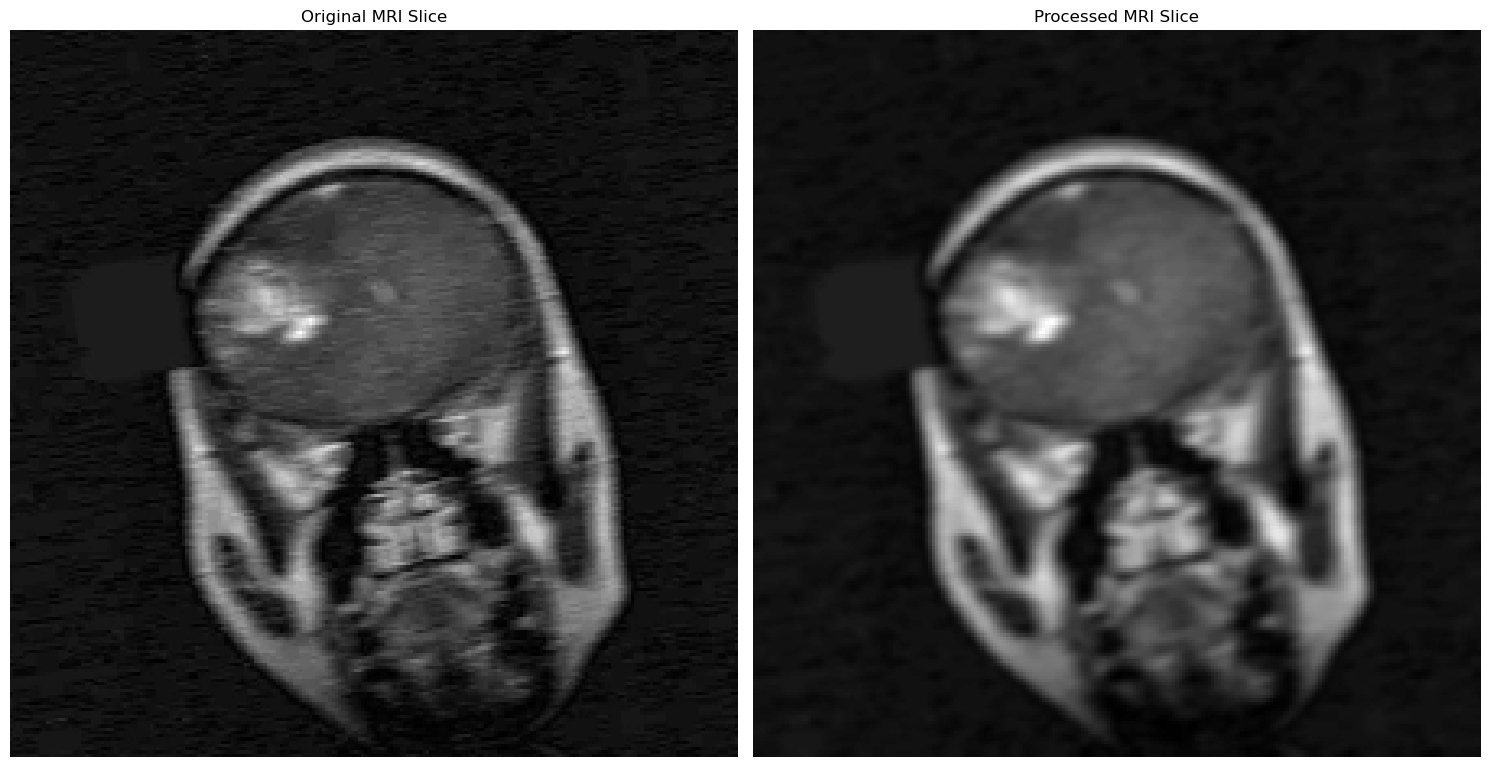

In [7]:

# Load and preprocess data
data = load_images_and_labels(root_dir, disease_names)
images, labels = preprocess_data(data)


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [9]:
# Prepare datasets
batch_size = 32
train_ds = prepare_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
test_ds = prepare_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

In [10]:
# Build model
input_shape = (224, 224, 1)  # grayscale images
num_classes = len(disease_names)
classifier = BrainMRIClassifierOptimized(input_shape, num_classes)
model = classifier.build_cnn()

TRAINING THE MODEL

In [ ]:
# Train model
history = model.fit(train_ds, epochs=20, validation_data=test_ds)
    
# Evaluate model
loss, accuracy, auc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}")

Epoch 1/20


143/143 ━━━━━━━━━━━━━━━━━━━━ 733s 5s/step - accuracy: 0.3631 - auc: 0.6237 - loss: 1.3455 - val_accuracy: 0.2458 - val_auc: 0.5228 - val_loss: 1.4179
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 698s 5s/step - accuracy: 0.4831 - auc: 0.7384 - loss: 1.1808 - val_accuracy: 0.2388 - val_auc: 0.5527 - val_loss: 1.4974
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 798s 6s/step - accuracy: 0.5304 - auc: 0.7804 - loss: 1.1069 - val_accuracy: 0.2782 - val_auc: 0.6504 - val_loss: 1.3846
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 724s 5s/step - accuracy: 0.5824 - auc: 0.8152 - loss: 1.0403 - val_accuracy: 0.4129 - val_auc: 0.7219 - val_loss: 1.2396
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 679s 5s/step - accuracy: 0.5997 - auc: 0.8300 - loss: 1.0036 - val_accuracy: 0.3815 - val_auc: 0.6850 - val_loss: 1.4444
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 733s 5s/step - accuracy: 0.6064 - auc: 0.8453 - loss: 0.9575 - val_accuracy: 0.5678 - val_auc: 0.8185 - val_loss: 1.0136
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 849s 

TESTING THE MODEL WITH TEST DATA

In [ ]:
# Loading the directory
new_root_dir = "Brain/Brain/dirty_test"
disease_names = ["glioma", "meningioma", "notumor", "pituitary"]

Total images loaded: 1310


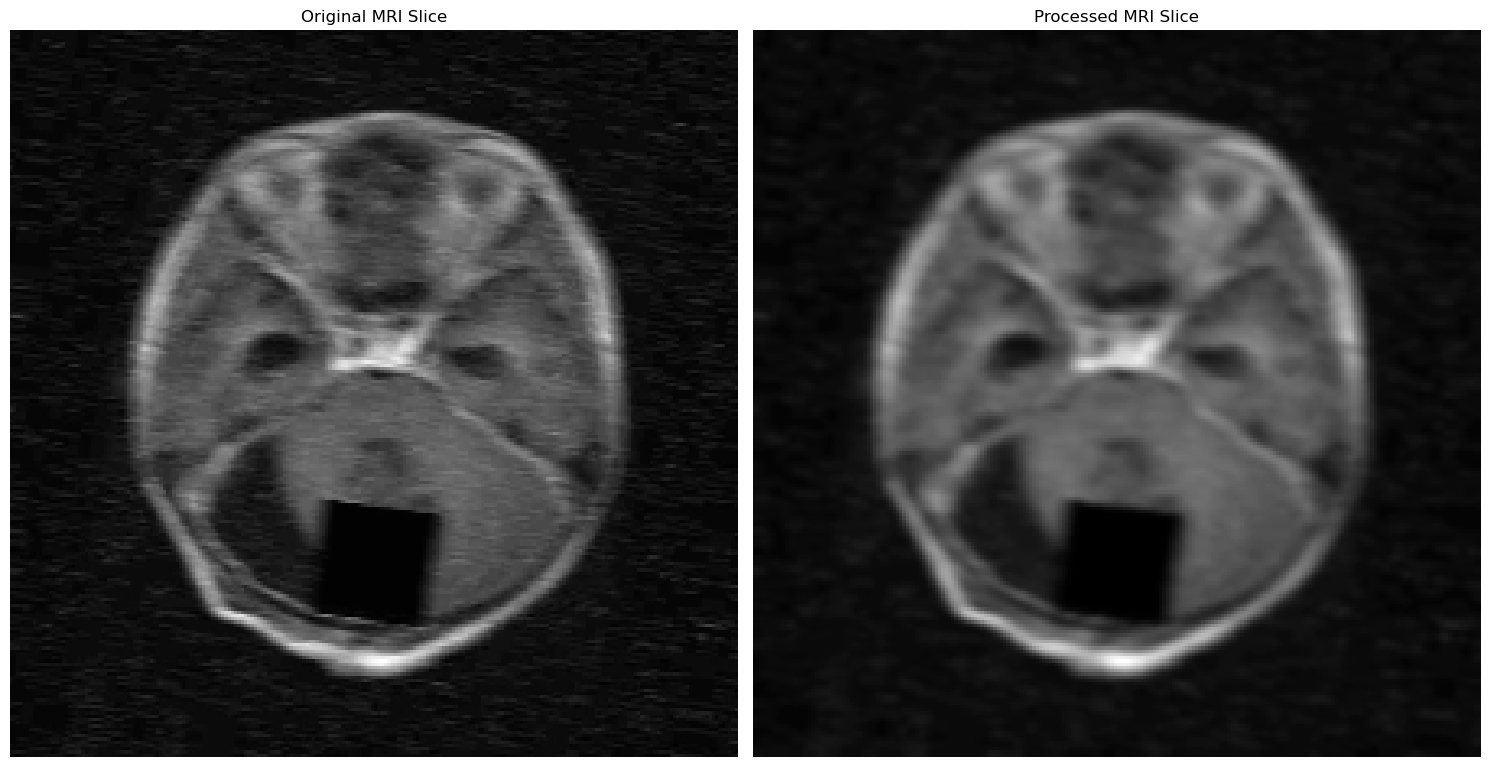

In [ ]:
# Loading and preprocessing the test data
data = load_images_and_labels(new_root_dir, disease_names)
images, labels = preprocess_data(data)

In [ ]:
 # Predict on multiple test images
for i in range(5):  # Change the range to test more images
    sample_img = X_test[i]
    sample_label = y_test[i]
    
    # Display the image
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title(f"True label: {disease_names[sample_label]}")
    plt.axis('off')
    plt.show()

In [ ]:
# Predict
pred_probs = model.predict(np.expand_dims(sample_img, axis=0))
pred_class = np.argmax(pred_probs[0])
print(f"Predicted label: {disease_names[pred_class]}, Confidence: {pred_probs[0][pred_class]:.4f}")